<a href="https://colab.research.google.com/github/ChiaraUsa/ML/blob/main/Parcial_Corte_2_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
<FONT FACE="times new roman" SIZE=5>
<br>
<i><b>Docente:</b> Ricardo Ándres Fonseca Perdomo.</i>
<br>
<i><b>Asignatura:</b> Aprendizaje de máquina</i>
<br>
<i><b>Tema:</b> 2do Parcial</i>
<br>
<i><b>Estudiantes:</b> <br>Chiara Vivian Valenzuela Losada <br> Oscar Eduardo Miranda Puentes<br> Mitchell Phillip Bermin Suarez</i>
<br>
<i>30/04/24</i>
<br>
</FONT>
</p>

#Importaciones

In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/drive')
import sys
assert sys.version_info >= (3, 7)
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
from pathlib import Path
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#Cargue y exploración del dataset

- Importamos las bibliotecas necesarias.
- Definimos una función para cargar los datos desde un archivo .npz.
- Comprobamos si el archivo existe antes de cargarlo para evitar errores.
- Extraemos los conjuntos de datos y etiquetas correspondientes.

In [ ]:
def load_mnist_data(file_path):
    if not Path(file_path).is_file():
        raise FileNotFoundError("El archivo MNIST no se encontró en la ruta especificada.")
    # Cargar los datos
    data = np.load(file_path)
    return data['training_data'].reshape(60000, 28, 28), data['training_labels'].reshape(60000,), data['test_data'].reshape(10000, 28, 28)

Referencias usadas [1] para la función `load_mnist_data()`



In [ ]:
# Ruta al archivo .npz
file_path = '/content/drive/MyDrive/ML/mnist-data.npz'
training_data, training_labels, test_data = load_mnist_data(file_path)

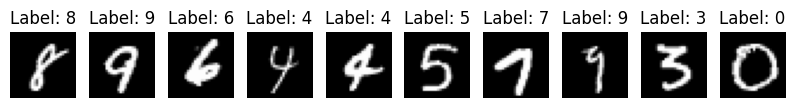

In [ ]:
# Visualizar las primeras 10 imágenes de entrenamiento
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i, ax in enumerate(axes):
    ax.imshow(training_data[i], cmap='gray')
    ax.set_title(f'Label: {training_labels[i]}')
    ax.axis('off')
plt.show()

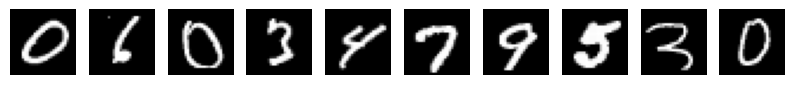

In [ ]:
# Visualizar las primeras 10 imágenes de test
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i, ax in enumerate(axes):
    ax.imshow(test_data[i], cmap='gray')
    ax.axis('off')
plt.show()

Referencias usadas [3] para la función visualizar las imágenes del conjunto de datos

In [ ]:
# Comprobando el balance de las etiquetas y la normalización
print("Distribución de etiquetas de entrenamiento:", np.unique(training_labels, return_counts=True))
print("Rango de valores de píxeles en los datos de entrenamiento:", training_data.min(), "a", training_data.max())

# Comprobar si es necesario preprocesar más
# Como los datos ya están normalizados y las etiquetas están balanceadas, no se necesita preprocesamiento adicional.

Distribución de etiquetas de entrenamiento: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5903, 6770, 5991, 6085, 5860, 5396, 5870, 6265, 5878, 5982]))
Rango de valores de píxeles en los datos de entrenamiento: 0.0 a 1.0


Distribución de etiquetas de entrenamiento:


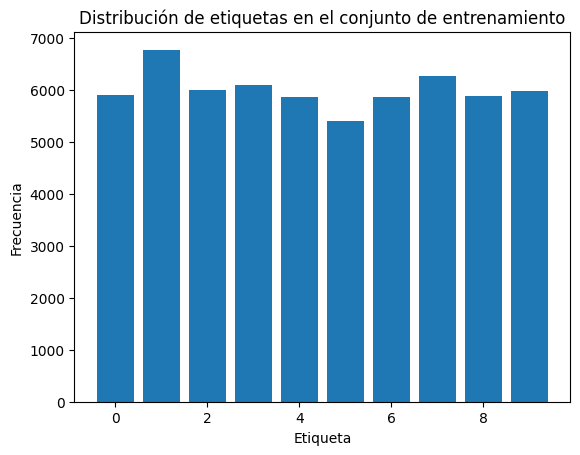

In [ ]:
# Análisis de la necesidad de preprocesamiento
# Comprobando si los datos están normalizados y si las etiquetas están balanceadas
print("Distribución de etiquetas de entrenamiento:")
unique, counts = np.unique(training_labels, return_counts=True)
plt.bar(unique, counts)
plt.title("Distribución de etiquetas en el conjunto de entrenamiento")
plt.xlabel("Etiqueta")
plt.ylabel("Frecuencia")
plt.show()

La gráfica muestra la distribución de las etiquetas en el conjunto de entrenamiento, y parece bastante uniforme, lo que es una excelente señal. Esto significa que cada clase de dígito tiene aproximadamente el mismo número de muestras, lo cual es deseable en un conjunto de datos para evitar sesgos hacia clases más frecuentes durante el entrenamiento del modelo.

Además, el rango de valores de píxeles es de 0.0 a 1.0, lo que indica que los datos ya han sido normalizados. La normalización es un paso importante en el preprocesamiento de datos para modelos de aprendizaje automático, especialmente para modelos basados en gradientes, ya que ayuda a que el entrenamiento sea más estable y rápido.

Con estos datos, se está en buena posición para proceder con la implementación de modelos de aprendizaje automático, como las máquinas de vectores de soporte (SVM), sin necesidad de preocuparse por el balance de clases o la normalización adicional de los datos.

In [ ]:
# Verificar si hay valores faltantes
def check_missing_values(data):
    if np.isnan(data).any():
        return True
    else:
        return False

missing_values_training_data = check_missing_values(training_data)
missing_values_training_labels = check_missing_values(training_labels)

print(f'Valores faltantes en los datos de entrenamiento: {missing_values_training_data}')
print(f'Valores faltantes en las etiquetas de entrenamiento: {missing_values_training_labels}')

Valores faltantes en los datos de entrenamiento: False
Valores faltantes en las etiquetas de entrenamiento: False


In [ ]:
# Verificar si hay valores atípicos
def check_outliers(data, min_val=0.0, max_val=1.0):
    if ((data < min_val) | (data > max_val)).any():
        return True
    else:
        return False

outliers_training_data = check_outliers(training_data)

print(f'Valores atípicos en los datos de entrenamiento: {outliers_training_data}')

Valores atípicos en los datos de entrenamiento: False


Referencias usadas [2] para la función `check_outliers()`



Se revisaron los conjuntos de datos para determinar si hay valores faltantes o atípicos. La verificación de valores faltantes es una práctica común en el preprocesamiento de datos para garantizar que el modelo de machine learning no se encuentre con entradas inesperadas que podrían causar errores o comportamientos impredecibles. Los valores faltantes pueden necesitar ser imputados o las muestras correspondientes podrían ser excluidas del entrenamiento.

La detección de valores atípicos es igualmente importante, ya que los valores extremos pueden influir desproporcionadamente en el entrenamiento del modelo, especialmente en algoritmos sensibles a la escala de los datos como las SVM o las redes neuronales. En el caso del MNIST, los valores atípicos podrían indicar problemas con el conjunto de datos o errores en el proceso de carga o normalización.

En este caso, no se han encontrado valores faltantes o valores atípicos, por lo que se proseguirá y se dará por finalizada la carga y exploración del dataset.


# Partición de los datos

- Función para mezclar los datos y dividirlos en conjuntos de entrenamiento y validación.
- Usamos permutación aleatoria para asegurar una distribución uniforme de las clases.
- Se reservan 10,000 imágenes para el conjunto de validación.

In [ ]:
# Establecer una semilla aleatoria para reproducibilidad
np.random.seed(42)

In [ ]:
# Función para mezclar y dividir el conjunto de datos
def shuffle_and_split_data(training_data, training_labels, validation_size=10000):
    # Generar índices aleatorios
    shuffled_indices = np.random.permutation(len(training_data))

    # Dividir los índices para los conjuntos de entrenamiento y validación
    validation_indices = shuffled_indices[:validation_size]
    train_indices = shuffled_indices[validation_size:]

    # Separar los datos y las etiquetas en conjuntos de entrenamiento y validación
    validation_data = training_data[validation_indices]
    validation_labels = training_labels[validation_indices]
    train_data = training_data[train_indices]
    train_labels = training_labels[train_indices]

    return train_data, train_labels, validation_data, validation_labels

Para la función `shuffle_and_split_data` se toma de referencia la función hecha en la clase de Aprendizaje de Máquina por el profesor Ricardo Fonseca.

In [ ]:
# Llamar a la función con los datos cargados previamente
train_data, train_labels, validation_data, validation_labels = shuffle_and_split_data(training_data, training_labels)

# Verificación de las longitudes de los conjuntos resultantes
print("Conjunto de Entrenamiento:", train_data.shape, train_labels.shape)
print("Conjunto de Validación:", validation_data.shape, validation_labels.shape)

Conjunto de Entrenamiento: (50000, 28, 28) (50000,)
Conjunto de Validación: (10000, 28, 28) (10000,)


La forma anterior de manejar los datos garantiza que la mezcla y la división sean consistentes entre los datos y las etiquetas, manteniendo la correspondencia entre las imágenes y sus etiquetas correspondientes. Es crucial para mantener la distribución de las clases en ambos conjuntos.

# Implementación del Algoritmo de entrenamiento

- Se define una función para entrenar el modelo SVM con diferentes tamaños de muestras.
- Se evalúa la precisión del modelo en los conjuntos de entrenamiento y validación.
- Se utiliza Matplotlib para graficar la precisión del modelo en función del tamaño del conjunto de entrenamiento.

In [ ]:
# Asegúrate de que los datos estén aplanados y que la división del conjunto de
# datos se haya realizado correctamente
train_data_flat = train_data.reshape(-1, 28*28)
validation_data_flat = validation_data.reshape(-1, 28*28)

# Números de ejemplos de entrenamiento para iterar
training_sizes = [100, 200, 500, 1000, 2000, 5000, 10000]

# Listas para guardar las precisiones
train_accuracies = []
validation_accuracies = []

In [ ]:
# Entrenar con diferentes tamaños del conjunto de entrenamiento
for size in training_sizes:
    # Entrenar el modelo SVM
    svm_l = SVC(kernel='linear')
    svm_l.fit(train_data_flat[:size], train_labels[:size])

    # Evaluar y almacenar la precisión en el conjunto de entrenamiento
    train_accuracy = accuracy_score(train_labels[:size],
                                    svm_l.predict(train_data_flat[:size]))
    train_accuracies.append(train_accuracy)

    # Evaluar y almacenar la precisión en el conjunto de validación
    validation_accuracy = accuracy_score(validation_labels,
                                         svm_l.predict(validation_data_flat))
    validation_accuracies.append(validation_accuracy)

    print(f"Tamaño del conjunto de entrenamiento: {size}, Precisión de entrenamiento: {train_accuracy}, Precisión de validación: {validation_accuracy}")

Tamaño del conjunto de entrenamiento: 100, Precisión de entrenamiento: 1.0, Precisión de validación: 0.778
Tamaño del conjunto de entrenamiento: 200, Precisión de entrenamiento: 1.0, Precisión de validación: 0.8448
Tamaño del conjunto de entrenamiento: 500, Precisión de entrenamiento: 1.0, Precisión de validación: 0.8623
Tamaño del conjunto de entrenamiento: 1000, Precisión de entrenamiento: 1.0, Precisión de validación: 0.8842
Tamaño del conjunto de entrenamiento: 2000, Precisión de entrenamiento: 1.0, Precisión de validación: 0.8923
Tamaño del conjunto de entrenamiento: 5000, Precisión de entrenamiento: 0.9998, Precisión de validación: 0.9137
Tamaño del conjunto de entrenamiento: 10000, Precisión de entrenamiento: 0.9966, Precisión de validación: 0.9197


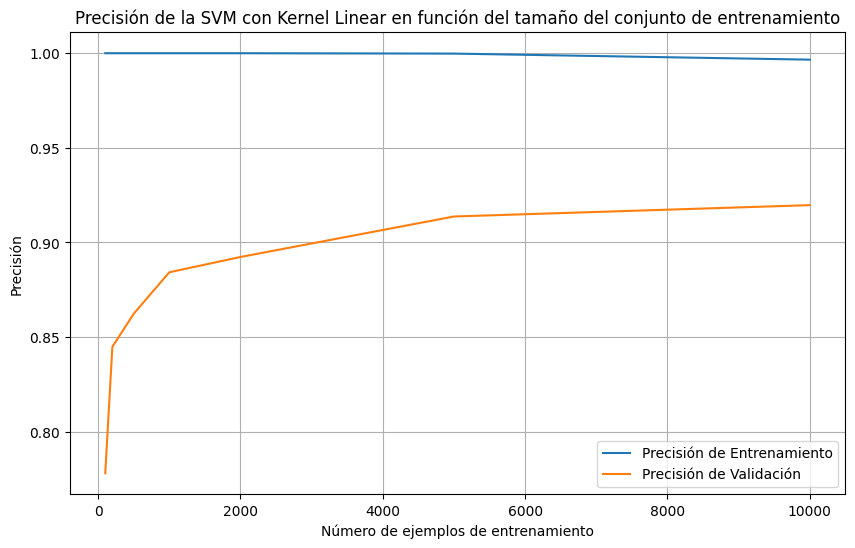

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies, label='Precisión de Entrenamiento')
plt.plot(training_sizes, validation_accuracies, label='Precisión de Validación')
plt.xlabel('Número de ejemplos de entrenamiento')
plt.ylabel('Precisión')
plt.title('Precisión de la SVM con Kernel Linear en función del tamaño del conjunto de entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

Los resultados indican que el modelo SVM lineal tiene un buen rendimiento en cuanto a precisión de entrenamiento, alcanzando la perfección o cerca de ella en los conjuntos más pequeños, y un rendimiento algo menor pero aún alto en los conjuntos más grandes. En cuanto a la precisión de validación, los resultados también muestran una mejora gradual conforme aumenta el tamaño del conjunto de entrenamiento.

### Análisis de los Resultados:
- **Precisión de entrenamiento**: El hecho de que la precisión de entrenamiento sea tan alta (incluso perfecta en los tamaños menores) puede indicar un sobreajuste en esos tamaños de entrenamiento más pequeños, especialmente porque el modelo está aprendiendo a clasificar perfectamente el conjunto de entrenamiento pero no generaliza igual de bien en el conjunto de validación.

- **Precisión de validación**: La precisión de validación mejora consistentemente a medida que se incrementa el número de ejemplos de entrenamiento. Esto es esperado, ya que un mayor número de ejemplos proporciona una representación más rica y diversa del espacio de características, permitiendo al modelo generalizar mejor. La precisión de validación llega hasta un 91.97% para 10,000 ejemplos de entrenamiento, lo cual está dentro del rango esperado de 70% a 90% mencionado en las instrucciones del examen.

### Sugerencias para Mejorar:
1. **Más datos o técnicas de augmentación**: Considerar el uso de más datos de entrenamiento o aplicar técnicas de augmentación de datos podría ayudar a mejorar la generalización del modelo, especialmente si los recursos lo permiten.

2. **Exploración de características adicionales**: Aunque el ejercicio especifica el uso de píxeles en bruto como características, en la práctica, la extracción de características más sofisticadas podría mejorar la capacidad del modelo para distinguir entre clases.

En resumen, los resultados son prometedores y muestran un buen ajuste inicial del modelo a los datos. La mejora continua de la precisión de validación con el aumento del tamaño del conjunto de entrenamiento es un indicativo positivo de que el modelo se está beneficiando de más datos para aprender las características del problema.

# Referencias

1. GfG, A. (2020, julio 1). Ways to import CSV files in Google Colab. GeeksforGeeks. https://www.geeksforgeeks.org/ways-to-import-csv-files-in-google-colab/

2. Khadija. (2021, septiembre 8). What if there is a lot of outliers in your dataset. Stack Overflow. https://stackoverflow.com/questions/69104651/what-if-there-is-a-lot-of-outliers-in-your-dataset

3. LeCun, Yann and Cortes, Corinna and Burges, CJ. (2010). MNIST handwritten digit database. TensorFlow. http://yann.lecun.com/exdb/mnist